In [10]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from enum import Enum

In [11]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

## Transform Data
The data is not normally distributed and will need to be transformed in some way. We can scale predictors as proportions $\frac{x}{max(x)}$, as each predictor has a different survey scale range (0-5, 0-7, 0-11, etc). Or we can apply natural log or square root operations to each predictor.

In [12]:
# Apply transformation to each variable

def transform(dataframe):
    for column in predictors:
        # Get proportion of responses.
        dataframe[column] = dataframe[column] / max(pre_df[column])

        # Apply log transform
        # dataframe[column] = np.where(dataframe[column] > 0, np.log(dataframe[column]), np.nan)

        # Apply square root transformation
        # dataframe[column] = np.sqrt(dataframe[column])

In [13]:
transformed_df = pre_df.copy()[predictors]

## (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [14]:
class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return pre_df[pre_df["Personality"] == personality.value[0]]
    else:
        return pre_df

pre_df = switch_personality()

In [15]:
import sklearn.metrics as metrics
import numpy as np


def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance, 4))
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [16]:
import numpy as np

def predict_interval(y, y_pred):
    # Calculate standard error of predictions
    std_err = np.std(y - y_pred)
    
    # Calculate lower and upper confidence intervals
    conf_int_lower = y_pred - 1.96 * std_err / np.sqrt(len(y))
    conf_int_upper = y_pred + 1.96 * std_err / np.sqrt(len(y))
    
    return np.column_stack((conf_int_lower, conf_int_upper))

In [17]:
from sklearn.utils import resample
import numpy as np

def bootstrap_confidence_interval(X, y, model):
    n_bootstraps = 1000
    predictions = []
    for _ in range(n_bootstraps):
        X_boot, y_boot = resample(X, y)
        pred_boot = model.predict(X_boot)
        predictions.append(pred_boot)
    ci_lower_bound, ci_upper_bound = np.percentile(predictions, [2.5, 97.5])
    return ci_lower_bound, ci_upper_bound

## Ridge Regression

In [18]:
X = transformed_df
y = pre_df['Friends_circle_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

# Alpha controls strength of L2 regularization
ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.6009
mean_squared_log_error:  0.2158
r2:  0.6007
MAE:  2.1238
MSE:  6.8809
RMSE:  2.6232


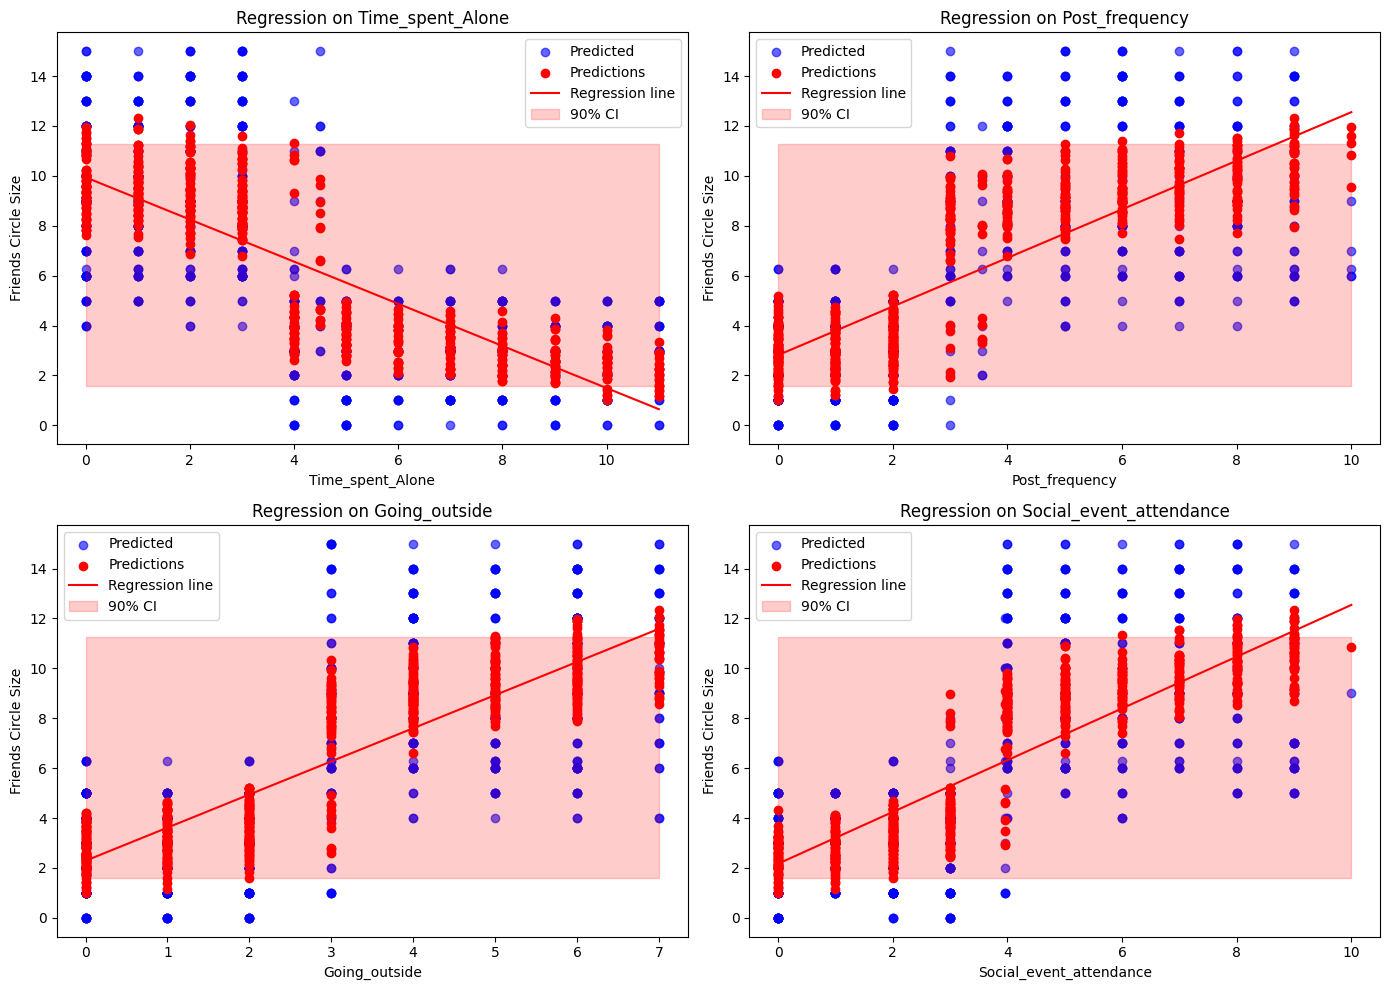

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]
    transformed_df = pre_df.copy()[predictors]
    X = transformed_df
    y = pre_df['Friends_circle_size']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    x_vals = np.linspace(X_train[predictor].min(), X_train[predictor].max(), 100)

    # Alpha controls strength of L2 regularization
    ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)

    y_pred = ridge_model.predict(X_test)

    # Plot points
    ax.scatter(
        x=X_test[predictor],
        y=y_test,
        color="blue",
        alpha=0.6,
        label="Predicted"
    )

    ax.scatter(
        X_test[predictor],
        y_pred,
        color='red',
        label='Predictions'
    )

    # Regression line
    z = np.polyfit(X_test[predictor], y_test, 1)
    p = np.poly1d(z)
    ax.plot(x_vals, p(x_vals), color='red', label='Regression line')

    # Confidence interval (Bootstrap)
    ci_lower_bound, ci_upper_bound = bootstrap_confidence_interval(X, y, ridge_model)

    # TODO: fix confidence interval
    ax.fill_between(
        x_vals,
        ci_lower_bound,
        ci_upper_bound,
        color='red',
        alpha=0.2,
        label='90% CI'
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Friends Circle Size')
    ax.legend()
plt.tight_layout()
plt.show()